In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from utils.tokenMaker import Lang
from utils.tool import padding, flatMutileLength, fixString
from model.BigModel import ImgToSeq
from convertSrtEN import cleanString
useCuda = True
Variable = Variable.cuda if useCuda else Variable

In [3]:
datas = pd.read_csv("train.csv")
datas[:5]

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
import pickle
import os
ModalDir = "ImgSub2Sub/models/bken_tanh"
with open(os.path.join(ModalDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModalDir, len(lang)))
modal = torch.load(os.path.join(ModalDir, "SubImgModel.14.pth")).eval()

Load lang model: ImgSub2Sub/models/bken_tanh. Word size: 15479


In [7]:
minidata = datas[:1000]
minidata = minidata.assign(cos = lambda x: 0.5)
minidata = minidata.assign(eucl = lambda x: 0.5)

In [8]:
def getEncoder(modal, sub):
    subVar =  Variable(torch.LongTensor(lang.sentenceToVector(sub, sos=False, eos=False)).unsqueeze(0))    
    return modal.subRnn(subVar)[0][:,-1,:]
def getWordEncoder(modal, sub):
    subVar =  Variable(torch.LongTensor(lang.sentenceToVector(sub, sos=False, eos=False)).unsqueeze(0))    
    return modal.subRnn.embedding(subVar).mean(dim=1)
def getCos(row):
    eq1 = getEncoder(modal, cleanString(row["question1"]))
    eq2 = getEncoder(modal, cleanString(row["question2"]))
    data = cos(eq1, eq2).mean() #cos
    return data.cpu().data[0]
def getEuclidean(row):
    eq1 = getEncoder(modal, cleanString(row["question1"]))
    eq2 = getEncoder(modal, cleanString(row["question2"]))
    data = ((eq1-eq2)**2).sum()**0.5 #o
    return data.cpu().data[0]

cos = nn.CosineSimilarity(dim=1)

In [9]:
for index, row in minidata.iterrows():
    minidata.loc[index, "cos"] = getCos(row)
    minidata.loc[index, "eucl"] = getEuclidean(row)

In [10]:
from sklearn.metrics import classification_report
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(minidata[["cos"]], minidata["is_duplicate"])
minidata["cmp"] = clf.predict(minidata[["cos"]])
print(classification_report(y_true=minidata["is_duplicate"], y_pred=minidata["cmp"]))
#cos

             precision    recall  f1-score   support

          0       0.73      0.70      0.72       620
          1       0.54      0.58      0.56       380

avg / total       0.66      0.66      0.66      1000



In [11]:
from sklearn.metrics import classification_report
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(minidata[["eucl"]], minidata["is_duplicate"])
minidata["cmp"] = clf.predict(minidata[["eucl"]])
print(classification_report(y_true=minidata["is_duplicate"], y_pred=minidata["cmp"]))
#幾何

             precision    recall  f1-score   support

          0       0.68      0.84      0.76       620
          1       0.59      0.36      0.45       380

avg / total       0.65      0.66      0.64      1000



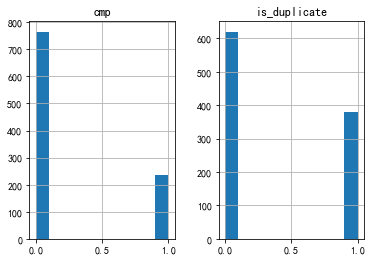

In [12]:
minidata[["cmp", "is_duplicate"]].hist()
plt.show()

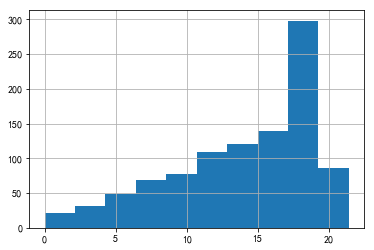

count    1000.000000
mean       13.987419
std         5.008799
min         0.000000
25%        10.745054
50%        15.444481
75%        18.080406
max        21.424009
Name: eucl, dtype: float64

In [13]:
minidata["eucl"].hist(bins=10)
plt.show()
minidata["eucl"].describe()

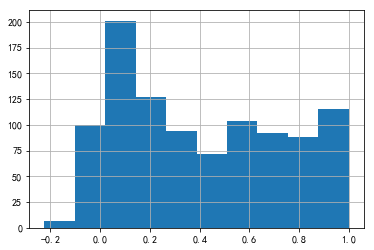

count    1000.000000
mean        0.404771
std         0.329108
min        -0.224379
25%         0.107949
50%         0.352437
75%         0.694705
max         1.000000
Name: cos, dtype: float64

In [14]:
minidata["cos"].hist(bins=10)
plt.show()
minidata["cos"].describe()